In [611]:
from scripts.models import VehTraj
from esper.widget import vgrid_widget
from vgrid import VideoBlockFormat, NestedFormat, NamedIntervalSet, IntervalBlock
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.poutine import trace
import math
from tqdm import tqdm_notebook as tqdm
from scripts.utils import img_grid, vgrid_traj
import pandas as pd
from rekall import IntervalSetMapping, IntervalSet, Interval, Bounds3D
from enum import Enum
from torch import tensor
import torch
from pyro import plate
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, JitTraceEnum_ELBO, config_enumerate
from pyro.optim import Adam
from pprint import pprint
from torch.distributions import constraints
from copy import copy
pyro.enable_validation(True)

In [712]:
video_meta = [v.for_vgrid() for v in Video.objects.all()]
vgrid_widget(
    video_meta=video_meta,
    vis_format=VideoBlockFormat(video_meta=video_meta))

VGridWidget(vgrid_spec={'interval_blocks': [{'video_id': 1, 'interval_sets': [{'interval_set': [{'payload': {'…

In [695]:
vehicles = list(Vehicle.objects.all())
trajectories = [VehTraj(veh) for veh in vehicles]

In [103]:
def eval_prob(fn, traj):
    return trace(fn).get_trace(traj).log_prob_sum().item()

def turning_right(traj):
    turn = traj.pos[0].psi - traj.pos[-1].psi
    pyro.sample("turn", dist.Normal(-math.pi/2, 0.3), obs=turn)
    
def turning_left(traj):
    turn = traj.pos[0].psi - traj.pos[-1].psi
    pyro.sample("turn", dist.Normal(math.pi/2, 0.3), obs=turn)

In [206]:
def compute_traj_probs(fn):
    traj_probs = np.array([eval_prob(fn, traj) for traj in trajectories])
    sorted_idxs = np.argsort(traj_probs)[::-1]
    return [trajectories[i] for i in sorted_idxs]

def compute_traj_scores(fn):
    traj_scores = np.array([fn(traj) for traj in trajectories])
    sorted_idxs = np.argsort(traj_scores)[::-1]
    return [trajectories[i] for i in sorted_idxs], traj_scores, sorted_idxs

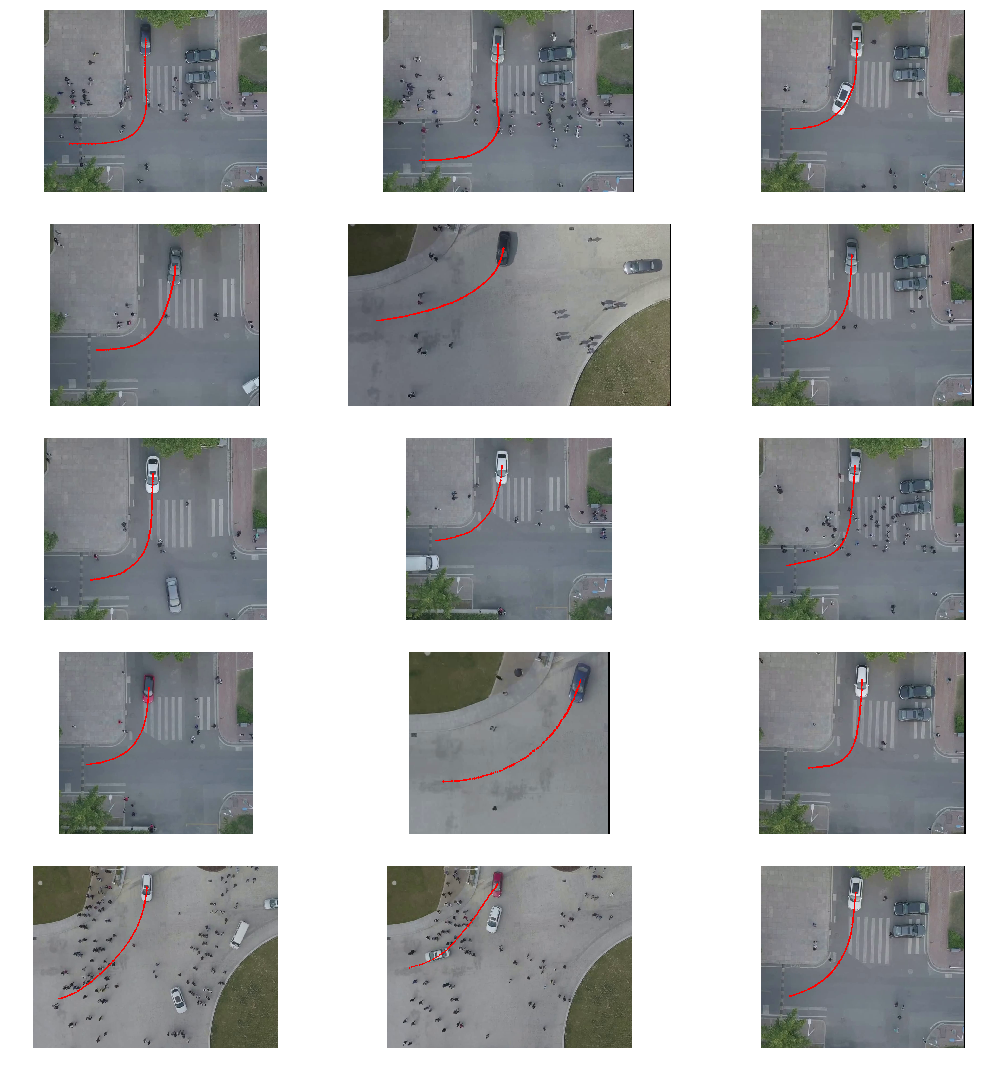

In [104]:
img_grid([t.draw() for t in compute_traj_probs(turning_right)[:15]])

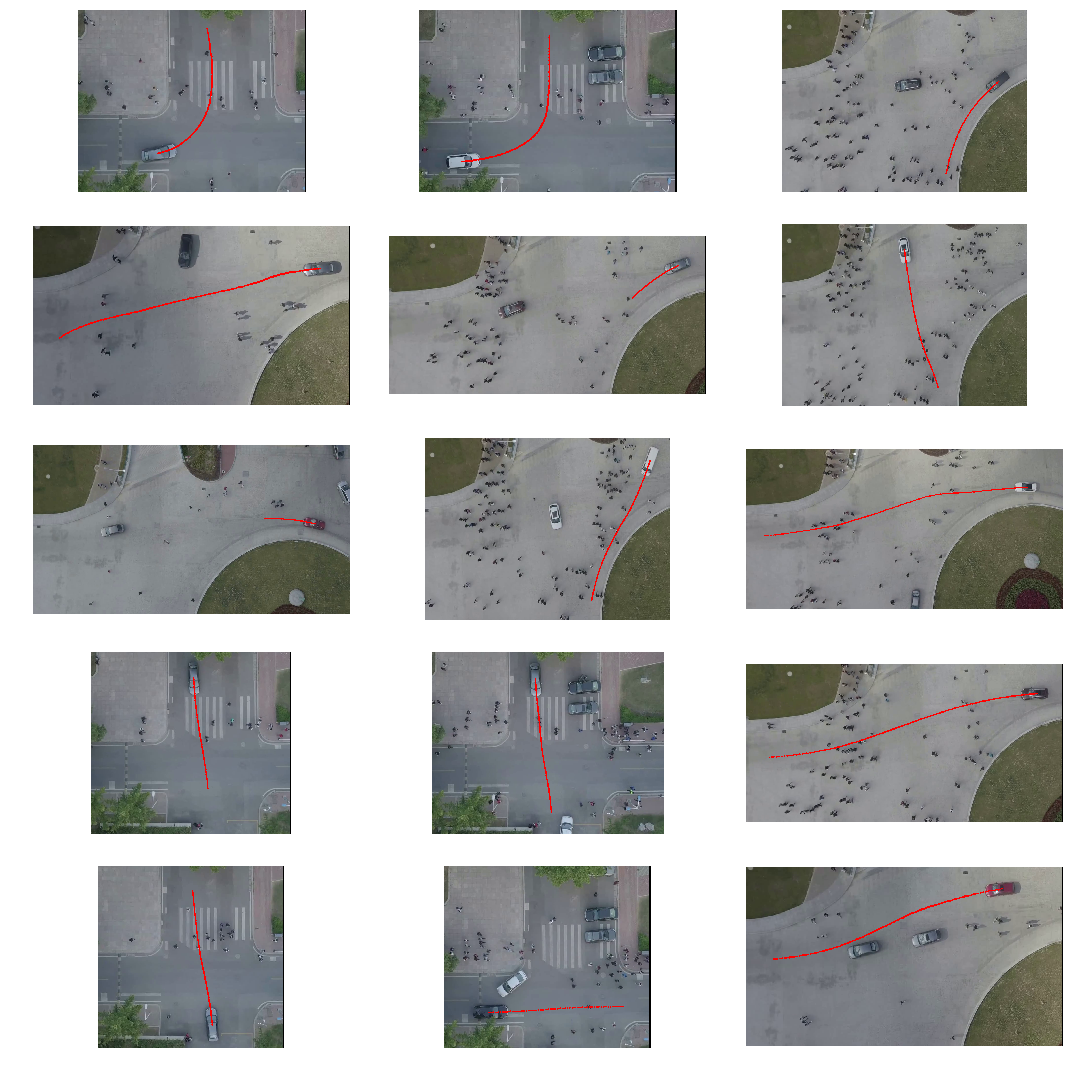

In [107]:
img_grid([t.draw() for t in compute_traj_probs(turning_left)[:15]])

In [227]:
def stops(traj):
    points = traj.for_numpy()
    vels = points[::2][1:] - points[::2][:-1]
    vel_mag = np.linalg.norm(vels, axis=1)
    accel = vel_mag[1:] - vel_mag[:-1]
    return -(pd.Series(accel).rolling(10, min_periods=1).sum().min())

#img_grid([t.draw() for t in compute_traj_scores(stops)[:15]])

In [ ]:
def stops(traj):
    points = traj.for_numpy()
    vels = points[::2][1:] - points[::2][:-1]
    vel_mag = np.linalg.norm(vels, axis=1)
    accel = vel_mag[1:] - vel_mag[:-1]
    return -(pd.Series(accel).rolling(10, min_periods=1).sum().min())

#img_grid([t.draw() for t in compute_traj_scores(stops)[:15]])

In [234]:
def signal_batch(signal, framerate):
    return [signal[i:i+framerate] for i in range(0, len(signal), framerate)]

In [696]:
class RandomCategory:
    @classmethod
    def sample(cls, name, prior=None):
        return cls.State(pyro.sample(name, dist.Categorical(prior if prior is not None else cls.prior)).item())

class MoveState(RandomCategory):
    class State(Enum):
        Moving = 0
        Slowing = 1
        Stopped = 2
        Speeding = 3
    
    prior = tensor([0.25, 0.25, 0.25, 0.25])

min_speed = tensor(0.)
max_speed = tensor(1.)
min_vel = tensor(0.2)
    
def velocity_model(N):
    state = MoveState.sample("state")
    if state == MoveState.State.Moving:
        vel_mu = pyro.sample("vel_mu", dist.Uniform(0.1, 1.))
        return tensor([
            pyro.sample(
                "vel{}".format(i), 
                dist.Normal(vel_mu, 0.02))
            for i in plate("vel_plate", N)
        ])
    elif state == MoveState.State.Slowing:
        init = pyro.sample("slowing_init", dist.Uniform(min_speed, max_speed))
        diff = min(pyro.sample("slowing_diff", dist.Normal(init, 0.1)).item(), init.item())
        return tensor([
            pyro.sample(
                'vel{}'.format(i),
                dist.Normal(init - diff * i / N, 0.05)
            )
            for i in range(N)
        ])
    elif state == MoveState.State.Speeding:
        init = pyro.sample("speeding_init", dist.Uniform(min_speed, max_speed))
        diff = pyro.sample("speeding_diff", dist.Uniform(min_vel, max_speed))
        return tensor([
            pyro.sample(
                'vel{}'.format(i),
                dist.Normal(init + diff * i / N, 0.05)
            )
            for i in range(N)
        ])
    elif state == MoveState.State.Stopped:
        return tensor([pyro.sample("vel{}".format(i), dist.Normal(0., 0.02))
                       for i in plate("vel_plate", N)])
      
def velocity_guide(data):
    state_param = pyro.param('state_param', MoveState.prior.clone(), constraint=constraints.simplex)
    vel_mu_param = pyro.param('vel_mu_param', 0.1, constraint=constraints.interval(tensor(0.1), tensor(1.)))=;=
    slowing_init_param = pyro.param(
        "slowing_init_param", data[0], constraint=constraints.interval(min_speed, max_speed))
    slowing_diff_param = pyro.param(
        "slowing_diff_param", min_vel, constraint=constraints.interval(min_vel, max_speed))
    speeding_init_param = pyro.param(
        "speeding_init_param", data[0], constraint=constraints.interval(min_speed, max_speed))
    speeding_diff_param = pyro.param(
        "speeding_diff_param", min_vel, constraint=constraints.interval(min_vel, max_speed))
        
    state = MoveState.sample("state", prior=state_param)
    if state == MoveState.State.Moving:
        pyro.sample("vel_mu", dist.Delta(vel_mu_param))
    elif state == MoveState.State.Slowing:
        pyro.sample("slowing_init", dist.Delta(slowing_init_param))
        pyro.sample("slowing_diff", dist.Delta(slowing_diff_param))
    elif state == MoveState.State.Speeding:
        pyro.sample("speeding_init", dist.Delta(speeding_init_param))
        pyro.sample("speeding_diff", dist.Delta(speeding_diff_param))

batches = []
batches_flat = []
batch_traj = []
batch_traj_flat = []
for traj in trajectories:
    fps = traj.obj.video.fps
    window_size = int(fps)
    points = traj.for_numpy()
    vels = points[::2][1:] - points[::2][:-1]
    vel_mag = np.linalg.norm(vels, axis=1)
    batches.append(signal_batch(vel_mag, window_size))
    batch_traj.append([traj.index(lambda t: t[i*window_size:(i+1)*window_size]) for i in range(len(batches[-1]))])

batches_flat = [b for l in batches for b in l]
batch_traj_flat = [t for l in batch_traj for t in l]

def classify_batch(batch):
    batch = torch.from_numpy(batch).float()
    cond_velocity_model = pyro.condition(
        lambda: velocity_model(len(batch)), 
        {"vel{}".format(i): batch[i] for i in range(len(batch))})
    cond_velocity_guide = config_enumerate((lambda: velocity_guide(batch)), "sequential")

    pyro.clear_param_store()
    cond_velocity_guide()

    svi = SVI(
        model=cond_velocity_model, 
        guide=cond_velocity_guide, 
        optim=Adam({'lr': 0.1}), 
        loss=TraceEnum_ELBO(max_plate_nesting=1))
    losses = []
    for _ in range(60):
        losses.append(svi.step())

    return {
        k: pyro.param(k).clone().detach()
        for k in ['state_param', 'vel_mu_param', 'slowing_init_param', 'slowing_diff_param',
                  'speeding_init_param', 'speeding_diff_param']
    }

pred_classes = [
    [classify_batch(batch) for batch in l]
    for l in tqdm(batches)
]

In [632]:
scores = np.array([p['state_param'][MoveState.State.Speeding.value].item() for l in pred_classes for p in l])
batches_sorted = np.argsort(scores)[::-1]

In [635]:
batches_flat[batches_sorted[0]]

array([0.04085102, 0.10430153, 0.17524687, 0.18930887, 0.19463869,
       0.21374943, 0.22160539, 0.22864332, 0.2342985 , 0.26027311,
       0.27610145, 0.27606072, 0.30340504, 0.30448502, 0.31160602,
       0.31406537, 0.34507031, 0.35803998, 0.35617024, 0.35834689])

In [633]:
vgrid_traj([batch_traj_flat[i] for i in batches_sorted[:100]])

VGridWidget(vgrid_spec={'interval_blocks': [{'video_id': 15, 'interval_sets': [{'interval_set': [{'payload': {…

In [636]:
movestate_posterior = [[p['state_param'] for p in l] for l in pred_classes]


In [655]:
def slowing_to_stop():
    slow_length = pyro.sample('slow_length', dist.Uniform(1, 100)).int()
    stop_length = pyro.sample('stop_length', dist.Uniform(1, 100)).int()
    states = []
    states.extend([
        MoveState.sample('slow_state_{}'.format(i), prior=tensor([0.1, 0.9, 0, 0]))
        for i in pyro.plate('slow_state_plate', slow_length.item())
    ])
    states.extend([
        MoveState.sample('stop_state_{}'.format(i), prior=tensor([0, 0, 1.0, 0]))
        for i in pyro.plate('stop_state_plate', stop_length.item())
    ])
    return states

In [ ]:
# pyro.clear_param_store()
# cond_velocity_guide()

# svi = SVI(
#     model=cond_velocity_model, 
#     guide=cond_velocity_guide, 
#     optim=Adam({'lr': 0.1}), 
#     loss=TraceEnum_ELBO(max_plate_nesting=1))
# losses = []
# for _ in range(60):
#     losses.append(svi.step())

In [704]:
def slowing_to_stop_match(mstate):
    N = len(mstate)
    scores = {}
    for i in range(N):
        for j in range(N):
            subseq = mstate[i:j]
            for k in range(1, len(subseq)-1):
                slowing, stopped = subseq[:k], subseq[k:]
                score = tensor([t[MoveState.State.Slowing.value] for t in slowing] + \
                    [t[MoveState.State.Stopped.value] for t in stopped])
                if i == 6 and j == 16 and k == 2:
                    print(score)
                scores[(i,j,k)] = score.log().sum() + tensor(len(subseq)).double().log()
    scores_flat = []
    index_flat = []
    for k, v in scores.items():
        index_flat.append(k)
        scores_flat.append(v)
        
    return scores_flat, index_flat
                

In [678]:
def nested_sort(scores, objects):
    flattened = [s for l in scores for s in l]
    index = [(i, j) for i, l in enumerate(scores) for j in range(len(l))]
    sorted_idxs = np.argsort(flattened)[::-1]
    return [
        objects[index[i][0]][index[i][1]]
        for i in sorted_idxs
    ]

In [675]:
all_scores = []
all_index = []
for i, (traj, mstate) in enumerate(zip(trajectories, movestate_posterior)):
    scores, index = slowing_to_stop_match(mstate)
    all_scores.append(scores)
    all_index.append([(i, j, k, l) for (j, k, l) in index])

In [679]:
sorted_objs = nested_sort(all_scores=, all_index)

In [709]:
_ = slowing_to_stop_match(movestate_posterior[57])
print(batches[57][6])
pred_classes[57][6]

tensor([0.9908, 0.9642, 0.9842, 0.9868, 0.9874, 0.9876, 0.9872, 0.9867, 0.9872,
        0.9530])
[0.02178562 0.03262453 0.0344832  0.02451318 0.02939979 0.03987419
 0.04091653 0.04741666 0.03690834 0.04156346 0.04729936 0.03320905
 0.042033   0.03730654 0.04368613 0.04839226 0.03834801 0.03793192
 0.04205689 0.04744148 0.05371673 0.04286502 0.04089376]


{'slowing_diff_param': tensor(0.2000),
 'slowing_init_param': tensor(0.0792),
 'speeding_diff_param': tensor(0.2000),
 'speeding_init_param': tensor(0.0037),
 'state_param': tensor([0.0047, 0.9908, 0.0017, 0.0028]),
 'vel_mu_param': tensor(0.1000)}

In [710]:
new_trajs = []
for (i, j, k, l) in sorted_objs[:100:10]:
    traj = trajectories[i]
    traj_parts = [
        batch_traj[i][j2]
        for j2 in range(j, k)
    ]
    print(i, j, k, l)
    new_traj = copy(traj_parts[0])
    new_traj.pos = new_traj.pos[:]
    for t in traj_parts[1:]:
        new_traj.pos += t.pos
    new_trajs.append(new_traj)
    
vgrid_traj(new_trajs)

/usr/local/lib/python3.5/dist-packages/django/db/models/base.py:316: RuntimeWarning: Model 'server.video' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label, new_class)
/usr/local/lib/python3.5/dist-packages/django/db/models/base.py:316: RuntimeWarning: Model 'server.pedestrian' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label, new_class)
/usr/local/lib/python3.5/dist-packages/django/db/models/base.py:316: RuntimeWarning: Model 'server.pedpos' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label, new_class)
/usr/local/lib/python3.5/dist-packages/django/db/models/base.py:316: Runt

57 6 16 2
57 6 11 2
11 0 12 1
57 5 15 3
10 1 12 1
57 8 15 1
41 0 7 1
11 1 10 1
10 4 12 1
29 0 6 1


VGridWidget(vgrid_spec={'interval_blocks': [{'video_id': 25, 'interval_sets': [{'interval_set': [{'payload': {…